Dataset loaded successfully.
Original shape: (568454, 10)

Missing values:
 Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64
Shape after cleaning: (393914, 10)


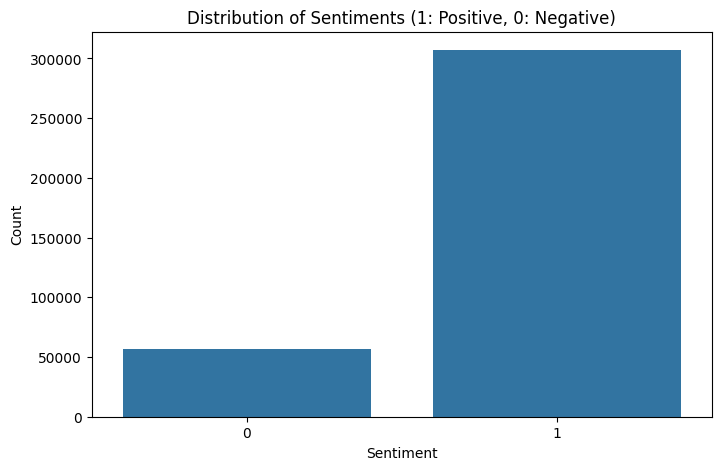


Sentiment distribution:
 Sentiment
1    307044
0     57103
Name: count, dtype: int64

Train set size: 32000
Test set size: 8000


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

file_path = "/content/drive/MyDrive/Colab Notebooks/Reviews.csv"
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
    print("Original shape:", df.shape)
except FileNotFoundError:
    print("Pastikan file 'Reviews.csv' sudah di-upload ke Colab.")

if not df.empty:
    #Cek missing values
    print("\nMissing values:\n", df.isnull().sum())
    df.dropna(inplace=True) #Hapus baris dengan nilai kosong

    #Hapus duplikat berdasarkan kombinasi UserID, ProfileName, Time, dan Text
    df.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'], keep='first', inplace=True)
    print("Shape after cleaning:", df.shape)

    #Abaikan skor 3 (netral)
    df_filtered = df[df['Score'] != 3].copy()
    #Buat label biner: 1 untuk Positif (skor 4-5), 0 untuk Negatif (skor 1-2)
    df_filtered['Sentiment'] = np.where(df_filtered['Score'] > 3, 1, 0)

    #Visualisasi Distribusi Target
    plt.figure(figsize=(8, 5))
    sns.countplot(x='Sentiment', data=df_filtered)
    plt.title('Distribution of Sentiments (1: Positive, 0: Negative)')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

    print("\nSentiment distribution:\n", df_filtered['Sentiment'].value_counts())

    #Split Data (Train/Test)
    positive_sample = df_filtered[df_filtered['Sentiment'] == 1].sample(n=20000, random_state=42)
    negative_sample = df_filtered[df_filtered['Sentiment'] == 0].sample(n=20000, random_state=42)
    df_balanced = pd.concat([positive_sample, negative_sample])

    X = df_balanced['Text']
    y = df_balanced['Sentiment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"\nTrain set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")

--- Training Logistic Regression ---

Logistic Regression - Classification Report:
              precision    recall  f1-score   support

    Negative       0.87      0.88      0.88      4000
    Positive       0.88      0.87      0.88      4000

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



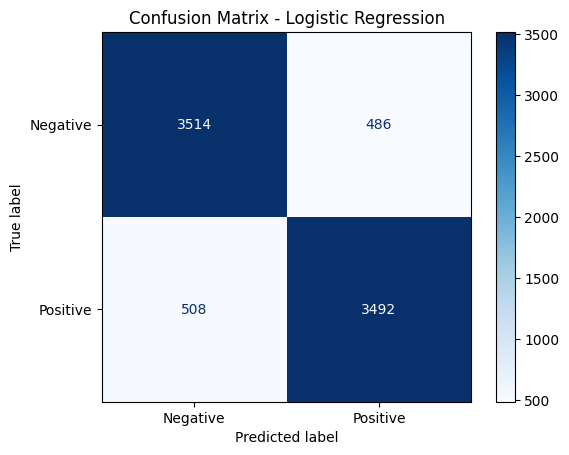


--- Training Random Forest ---

Random Forest - Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.84      0.84      4000
    Positive       0.84      0.84      0.84      4000

    accuracy                           0.84      8000
   macro avg       0.84      0.84      0.84      8000
weighted avg       0.84      0.84      0.84      8000



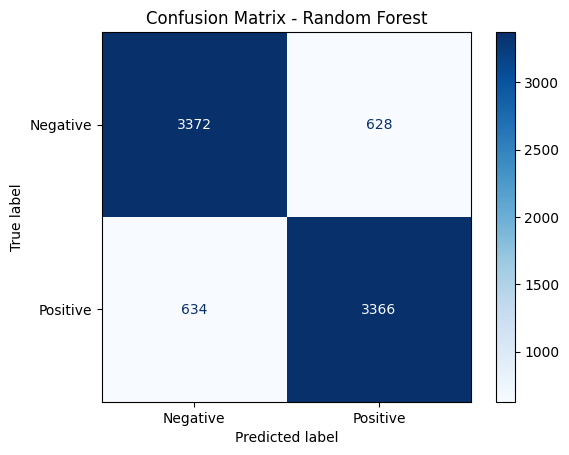

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Model Baseline 1: Logistic Regression
print("--- Training Logistic Regression ---")
#Buat pipeline: TF-IDF Vectorizer -> Logistic Regression Classifier
logreg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])

#Training model
logreg_pipeline.fit(X_train, y_train)

#Prediksi
y_pred_logreg = logreg_pipeline.predict(X_test)

#Evaluasi
print("\nLogistic Regression - Classification Report:")
print(classification_report(y_test, y_pred_logreg, target_names=['Negative', 'Positive']))

#Visualisasi Confusion Matrix
cm_logreg = confusion_matrix(y_test, y_pred_logreg)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=['Negative', 'Positive'])
disp_logreg.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Logistic Regression')
plt.show()


#Model Baseline 2: Random Forest
print("\n--- Training Random Forest ---")
#Buat pipeline: TF-IDF Vectorizer -> Random Forest Classifier
rf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000)),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
])

#Training model
rf_pipeline.fit(X_train, y_train)

#Prediksi
y_pred_rf = rf_pipeline.predict(X_test)

#Evaluasi
print("\nRandom Forest - Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=['Negative', 'Positive']))

#Visualisasi Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['Negative', 'Positive'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.show()

In [15]:
!pip install langchain-community replicate -q

from langchain_community.llms import Replicate
import os
from google.colab import userdata
import pandas as pd
import json

try:
    api_token = userdata.get('REPLICATE_API_TOKEN')
    os.environ["REPLICATE_API_TOKEN"] = api_token
    print("REPLICATE_API_TOKEN loaded successfully.")
except userdata.SecretNotFoundError:
    print("Secret 'REPLICATE_API_TOKEN' not found. Please add it to Colab Secrets.")
    api_token = None

if api_token:
    llm = Replicate(
        model="ibm-granite/granite-3.3-8b-instruct",
        replicate_api_token=api_token,
        model_kwargs={"temperature": 0.2, "max_new_tokens": 512} # Sesuaikan parameter
    )
    print("Granite model initialized.")

negative_reviews_text = X_test[y_test == 0].head(10)
summaries = []

map_prompt_template = """
Instruction: You are an expert product analyst. Summarize the key complaint points from the following customer review in 2-3 bullet points. Focus only on actionable issues related to the product, packaging, or delivery. If there are no clear issues, write "No specific issue identified".

Review:
"{review_text}"

Summary:
"""

print("\n--- Starting 'Map' Phase: Summarizing individual reviews... ---")
if api_token:
    for i, review_text in enumerate(negative_reviews_text):
        prompt = map_prompt_template.format(review_text=review_text)

        summary = llm.invoke(prompt)
        summaries.append(summary)

        print(f"--- Review #{i+1} Summary ---")
        print(summary)
        print("-" * 25)
else:
    print("Skipping 'Map' phase because API token is missing.")


reduce_prompt_template = """
Instruction: You are a Head of Customer Experience. You have received a collection of summarized complaint points from multiple negative reviews. Analyze these points and generate a final report that identifies the top 3-5 recurring themes. For each theme, provide a brief description and one direct quote as an example from the provided summaries.

Summarized Points:
"{list_of_summaries}"

Final Report:
"""

print("\n--- Starting 'Reduce' Phase: Synthesizing a final report... ---")
final_report = "API token not available. Final report could not be generated."

if api_token and summaries:
    all_summaries_text = "\n\n".join(summaries)

    final_prompt = reduce_prompt_template.format(list_of_summaries=all_summaries_text)

    final_report = llm.invoke(final_prompt)
else:
    if not api_token:
        print("Skipping 'Reduce' phase because API token is missing.")
    else:
        print("Skipping 'Reduce' phase because there are no summaries to process.")

print("\n--- FINAL SUMMARIZATION REPORT FROM GRANITE ---")
print(final_report)


report_data = {'final_summary_report': final_report}
with open('summarization_report.json', 'w') as f:
    json.dump(report_data, f, indent=4)

print("\nLaporan ringkasan berhasil disimpan ke 'summarization_report.json'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
✅ REPLICATE_API_TOKEN loaded successfully.
✅ Granite model initialized.

--- Starting 'Map' Phase: Summarizing individual reviews... ---
--- Review #1 Summary ---
1. The customer expresses disappointment with the taste of the organic peaches, describing it as having a "weird flavor" and a "chemical sweet taste," potentially due to the use of apple juice concentrate instead of pear.
2. The customer found the taste unpleasant when consumed on their own and suggests that the product might be more suitable for use in other dishes or recipes rather than as a standalone snack.

No specific issues related to packaging or delivery are identified in this review.
-------------------------
-

/tmp/ipython-input-1903645829.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Frequency', y='Theme', data=df_themes, palette='plasma', orient='h')


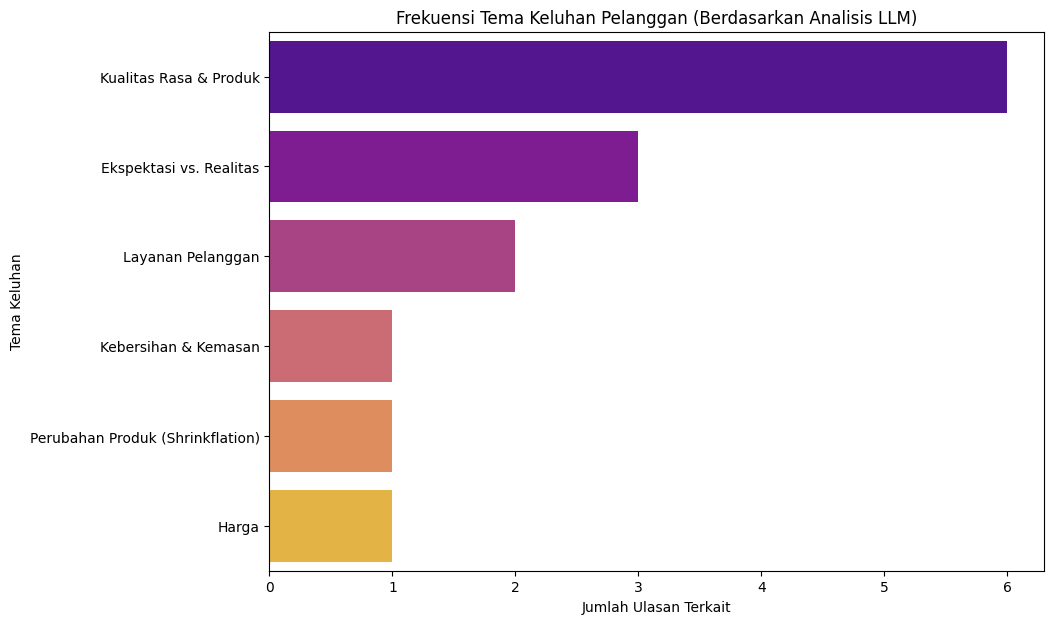

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

complaint_data = {
    'Theme': [
        'Kualitas Rasa & Produk',
        'Ekspektasi vs. Realitas',
        'Kebersihan & Kemasan',
        'Layanan Pelanggan',
        'Perubahan Produk (Shrinkflation)',
        'Harga'
    ],
    'Frequency': [
        6, # Didukung oleh ulasan 1, 3, 5, 8, 9, 10
        3, # Didukung oleh ulasan 2, 9, 7
        1, # Didukung oleh ulasan 6
        2, # Didukung oleh ulasan 3 (positif), 8 (negatif)
        1, # Didukung oleh ulasan 4
        1  # Didukung oleh ulasan 7
    ]
}

df_themes = pd.DataFrame(complaint_data)
df_themes = df_themes.sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x='Frequency', y='Theme', data=df_themes, palette='plasma', orient='h')
plt.title('Frekuensi Tema Keluhan Pelanggan (Berdasarkan Analisis LLM)')
plt.xlabel('Jumlah Ulasan Terkait')
plt.ylabel('Tema Keluhan')
plt.show()